# Codimension 2 bifurcations of periodic orbits in MatCont 

In this tutorial we show how to construct the bifurcation diagram in Figure 1, originally proposed in [1]. 

In [1] the following periodic predator-prey model is considered

\begin{equation}
\tag{1}
\label{eq:predator_prey_model}
\begin{cases}
\dot x = r\left( 1 - \frac x K \right) x - p(x,t)y,\\
\dot y = e p(x,t)y - dy,
\end{cases}
\end{equation}

where where $x$ and $y$ are the numbers of individuals, respectively of prey and predator populations or suitable (but equivalent) measures of density or biomass. The parameters present in system (1) are the intrinsic growth rate $r$, the carrying capacity $K$, the efficiency e and the death rate d of the predator. The function $p(x, t)$ is a functional response, for which the Holling type II is chosen, with constant attack rate a and half saturation $b(t)$ that varies periodically with period one (year), i.e.

$$
p(x,t) = \frac{ax}{b(t)+x}, \qquad b(t) = b_0 (1+\epsilon \cos{2\pi t}).
$$

Instead of system (1), we consider the extended autonomous system

\begin{cases}
\tag{2}
\dot x = r \left( 1 - \dfrac x K \right) x 
         - \dfrac{axy}{b_0(1+\epsilon u) + x},\\
\dot y = e \dfrac{axy}{b_0(1+\epsilon) + x} - dy, \\
\dot u = u - 2\pi v - (u^2 + v^2)u, \\
\dot v = 2\pi u + v - (u^2 + v^2)v,
\end{cases}

where the last two equations are decoupled from the last two and have a stable limit cycle with $u(t) = \cos(2\pi t + \phi), v(t) = \sin(2\pi t + \phi)$, and a phase shift $\phi$ depending on the initial conditions.

See [Codimension 2 bifurcations of periodic orbits in MatCont](http://www.staff.science.uu.nl/~kouzn101/NBA/LCNF.pdf) for the GUI version.

## Generate the system file

In [1]:
matcontpath = '../../';
addpath(matcontpath);
addpath([matcontpath, '/Utilities']);
if isOctave
  pkg load symbolic % for GNU Octave
end
system_name = 'Forced_prey_predator';

## Define the system using symbolic algebra

In [2]:
coordsnames = {'x', 'y', 'u', 'v'};
parnames = {'K', 'r', 'a', 'b0', 'e', 'd', 'epsilon'};

syms(parnames{:});       % create symbol for alpha and delta
par=cell2sym(parnames);  % now alpha1 is par(1) etc
syms(coordsnames{:});    % create symbol for alpha and delta
coords=cell2sym(coordsnames); % create 1 x n vector for coordinates

dx_dt = r*(1-x/K)*x - a*x*y/(b0*(1+epsilon*u)+x);
dy_dt = e*a*x*y/(b0*(1+epsilon*u)+x) - d*y;
du_dt = u - 2*pi*v - (u^2+v^2)*u;
dv_dt = 2*pi*u + v - (u^2+v^2)*v;
system = [dx_dt; dy_dt; du_dt; dv_dt];

## Differentiate and generate code, exporting it to system_name (multi-linear forms)

In [3]:
generate_system_file = 0;
if generate_system_file
    suc = generate_directional_derivatives(...
      system,...   % n x 1 array of derivative symbolic expressions
      coords,... % 1 x n array of symbols for states
      par,...      % 1 x np array of symbols used for parameters
      system_name,... % argument specifying the system name
      [matcontpath, 'Systems/']... % directory to save to file
    );
end

## Load various paths for files that are needed for this demo

In [4]:
addpath([matcontpath, 'Systems'])
addpath([matcontpath, 'Equilibrium'])
addpath([matcontpath, 'LimitPoint'])
addpath([matcontpath, 'Hopf'])
addpath([matcontpath, 'Homoclinic'])
addpath([matcontpath, 'LimitCycle'])
addpath([matcontpath, 'LimitPointCycle']);
addpath([matcontpath, 'Continuer'])
addpath([matcontpath, 'MultilinearForms'])
addpath([matcontpath, 'NeimarkSacker'])
addpath([matcontpath, 'PeriodDoubling'])
addpath([matcontpath, 'LimitCycleCodim2'])
% Define system file
odefile = @Forced_prey_predator;

## Find an initial periodic solution by simulation 

In [5]:
parnames = {'K', 'r', 'a', 'b0', 'e', 'd', 'epsilon'};
cind = [parnames;num2cell(1:length(parnames))];
ind  = struct(cind{:});
p(ind.K)  = 1;
p(ind.r)  = 6.28;
p(ind.a)  = 12.56;
p(ind.b0) = 0.25;
p(ind.e)  = 1;
p(ind.d)  = 6.28;
p(ind.epsilon) = 0.2;
x0  = [0.1; 0.1; 1; 0];

In [6]:
out = Forced_prey_predator;
dydt = out{2};

In [7]:
t0 = 0;
tfinal = 15;
pcell = num2cell(p, 1);
dydt_tx = @(t, x) dydt(t, x, pcell{:});
[t, x]  = ode23(dydt_tx, [t0 tfinal], x0);

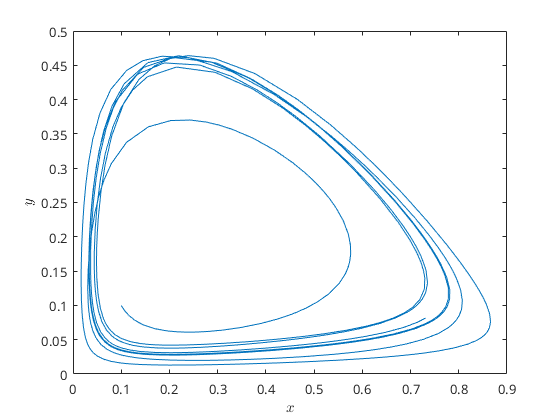

In [8]:
plot(x(:,1), x(:,2));
xlabel('$x$', 'Interpreter', 'LaTeX')
ylabel('$y$', 'Interpreter', 'LaTeX')

### Select last part of the orbit

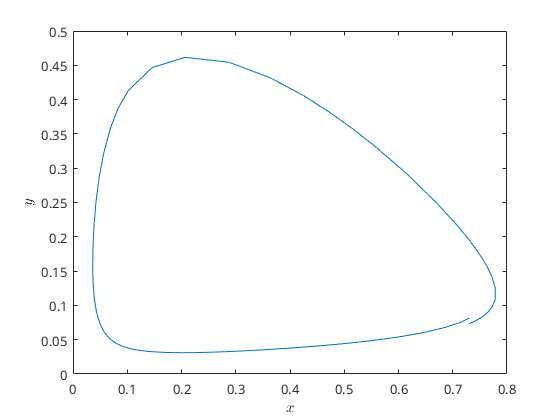

In [9]:
plot(x(end-62:end,1), x(end-62:end,2));
xlabel('$x$', 'Interpreter', 'LaTeX')
ylabel('$y$', 'Interpreter', 'LaTeX')

### Obtain initial prediction for continuation of the limit cycle

In [10]:
ntst = 20;
ncol = 4;
tolerence = 1e-05;
p = p'; % take transpose, otherwise an error will occure later on when using init_LPC_LPC
[lc_pred, lc_pred_v] = initOrbLC(odefile, t(end-62:end), x(end-62:end,:), p, ind.b0, ...
    ntst, ncol, tolerence);

### Continue limit cycle curve in $b_0$

We disable the detection of branch point cycle bifurcations by setting `IgnoreSingularity` to 1.

In [11]:
opt = contset;
opt.MinStepsize   = 1e-05;
opt.InitStepsize  = 0.01;
opt.MaxStepsize   = 0.5;
opt.MaxNumPoints  = 30;
opt.Singularities = 1;
opt.IgnoreSingularity = 1;
[lcbr, lcbr_v, lcbr_bif_data, h, multipliers] = ...
       cont(@limitcycle, lc_pred, lc_pred_v, opt);

first point found
tangent vector to first point found
Limit point cycle (period = 2.000000e+00, parameter = 3.399917e-01)
Normal form coefficient = -9.474702e+07
Limit point cycle (period = 2.000000e+00, parameter = 2.213011e-01)
Normal form coefficient = -1.699320e+08

elapsed time  = 1.4 secs
npoints curve = 30


## Plot cycles `lcbr` as manifold

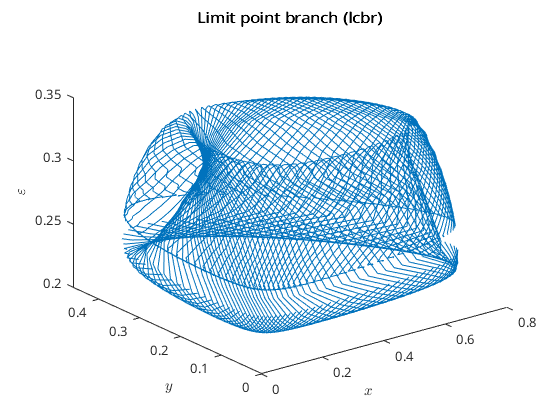

In [12]:
cmap = lines;
epsilon_ind = 4*(ntst*ncol+1)+2;
plot3(lcbr(1:4:4*(ntst*ncol+1),:), lcbr(2:4:4*(ntst*ncol+1),:), ...
    lcbr(epsilon_ind,:),'color', cmap(1,:))
xlabel('$x$', 'Interpreter', 'LaTeX')
ylabel('$y$', 'Interpreter', 'LaTeX')
zlabel('$\varepsilon$', 'Interpreter', 'LaTeX')
title('Limit point branch (lcbr)')

### Continue the initial prediction in $\epsilon$

In [13]:
[lc_pred, lc_pred_v] = initOrbLC(odefile, t(end-62:end), x(end-62:end,:), ...
    p, ind.epsilon, ntst, ncol, tolerence);
opt.Backward = 1;
opt.MaxNumPoints = 30;
[lcbr_pd, ~, lcbr_pd_bif_data] = ...
       cont(@limitcycle, lc_pred, lc_pred_v, opt);

first point found
tangent vector to first point found
Period Doubling (period = 2.000000e+00, parameter = 3.417856e-01)
Normal form coefficient = -2.750762e-01
Limit point cycle (period = 2.000000e+00, parameter = 5.896252e-02)
Normal form coefficient = -4.315875e+09
Neutral Saddle Cycle (period = 2.000000e+00, parameter = 3.761056e-01)

elapsed time  = 1.1 secs
npoints curve = 30


## Continue limit point of cycles curves detected on the branch `lcbr`

In [14]:
lpc_point_info = lcbr_bif_data(strcmp({lcbr_bif_data.label}, 'LPC')==1);

In [15]:
warning('off', 'MATLAB:nearlySingularMatrix');
warning('off', 'MATLAB:singularMatrix');
opt.Backward = 0;
[lpc_pred, lpc_pred_v] = init_LPC_LPC(odefile, lcbr, ...
    lpc_point_info(1), [ind.epsilon ind.b0], ntst, ncol);
[lpcbr, ~, lpcbr_bif_data] = cont(@limitpointcycle, lpc_pred, lpc_pred_v, opt);
opt.Backward = 1;
[lpc_pred, lpc_pred_v] = init_LPC_LPC(odefile, lcbr, ...
    lpc_point_info(1), [ind.epsilon ind.b0], ntst, ncol);
[lpcbr_rev, ~, lpcbr_rev_bif_data] = cont(@limitpointcycle, lpc_pred, lpc_pred_v, opt);

first point found
tangent vector to first point found

elapsed time  = 9.4 secs
npoints curve = 30
first point found
tangent vector to first point found
Current step size too small (point 22)
elapsed time  = 5.6 secs
npoints curve = 22


### Plot `lpcbr(_rev)` in parameter space $(\varepsilon, b_0)$

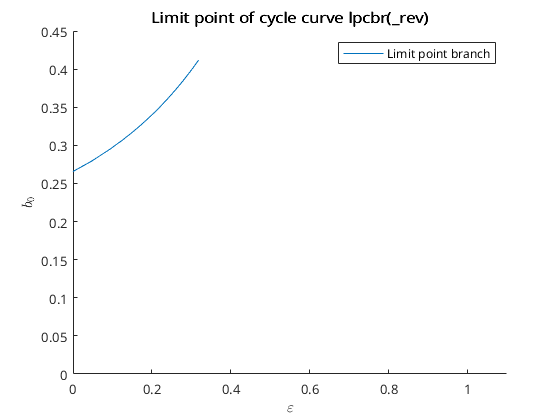

In [16]:
hold on
b0_ind = 4*(ntst*ncol+1)+3;
plot(lpcbr(epsilon_ind,:), lpcbr(b0_ind,:))
plot(lpcbr_rev(epsilon_ind,:), lpcbr_rev(b0_ind,:), 'color', cmap(1,:))
xlabel('$\varepsilon$', 'Interpreter', 'LaTeX')
ylabel('$b_0$', 'Interpreter', 'LaTeX')
title('Limit point of cycle curve lpcbr(\_rev)')
legend('Limit point branch')
axis([0 1.1 0 0.45])

### Continue second detected limit point of cycle bifurcation on the branch `lcbr`

In [17]:
[lpc2_pred, lpc2_pred_v] = init_LPC_LPC(odefile, lcbr, ...
    lpc_point_info(2), [ind.epsilon ind.b0], ntst, ncol);
opt.Backward = 0;
[lpcbr2, ~, lpcbr2_bif_data] = cont(@limitpointcycle, lpc2_pred, lpc2_pred_v, opt);
[lpc2_pred, lpc2_pred_v] = init_LPC_LPC(odefile, lcbr, ...
    lpc_point_info(2), [ind.epsilon ind.b0], ntst, ncol);
opt.Backward = 1;
opt.MaxNumPoints = 22;
[lpcbr2_rev, ~, lpcbr2_rev_bif_data] = cont(@limitpointcycle, lpc2_pred, lpc2_pred_v, opt);

first point found
tangent vector to first point found

elapsed time  = 7.5 secs
npoints curve = 30
first point found
tangent vector to first point found

elapsed time  = 6.2 secs
npoints curve = 22


### Plot `lpcbr(_rev)` and `lpcbr2(_rev)` in parameter space $(\varepsilon, b_0)$

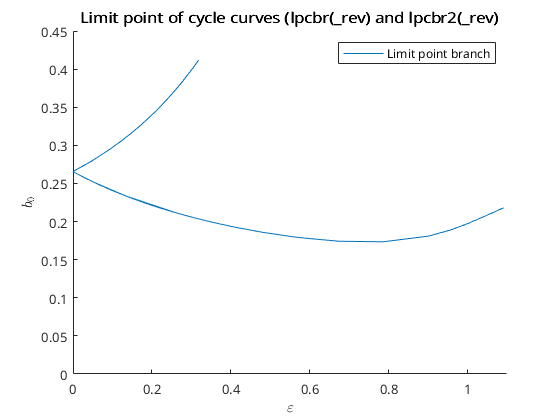

In [18]:
hold on
plot(lpcbr(epsilon_ind,:), lpcbr(b0_ind,:))
plot(lpcbr_rev(epsilon_ind,:), lpcbr_rev(b0_ind,:), 'color', cmap(1,:))
plot(lpcbr2(epsilon_ind,:), lpcbr2(b0_ind,:), 'color', cmap(1,:))
plot(lpcbr2_rev(epsilon_ind,:), lpcbr2_rev(b0_ind,:), 'color', cmap(1,:))
xlabel('$\varepsilon$', 'Interpreter', 'LaTeX')
ylabel('$b_0$', 'Interpreter', 'LaTeX')
title('Limit point of cycle curves (lpcbr(\_rev) and lpcbr2(\_rev)')
axis([0 1.1 0 0.45])
legend('Limit point branch')

## Find a second initial periodic solution by simulation

In [19]:
parnames = {'K', 'r', 'a', 'b0', 'e', 'd', 'epsilon'};
cind = [parnames;num2cell(1:length(parnames))];
ind  = struct(cind{:});
p(ind.b0) = 0.4;
p(ind.epsilon) = 0.2;
x0  = [0.1; 0.1; 1; 0];

In [20]:
t0 = 0;
tfinal = 100;
pcell = num2cell(p', 1);
dydt_tx = @(t, x) dydt(t, x, pcell{:});
[t, x]  = ode23(dydt_tx, [t0 tfinal], x0);

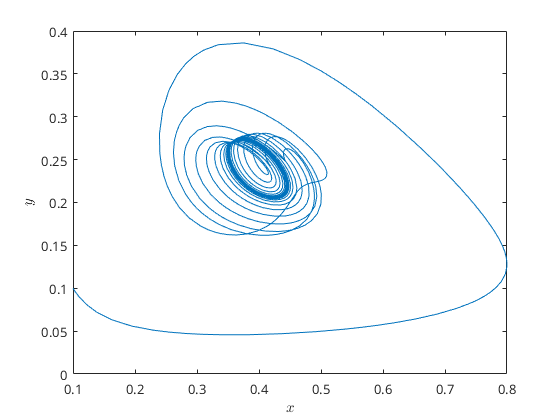

In [21]:
plot(x(:,1), x(:,2));
xlabel('$x$', 'Interpreter', 'LaTeX')
ylabel('$y$', 'Interpreter', 'LaTeX')

### Select last part of the orbit

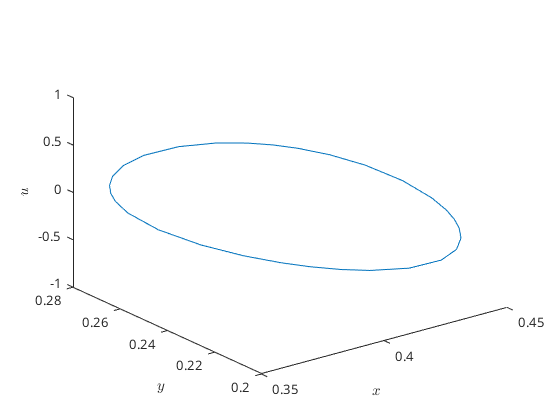

In [22]:
plot3(x(end-30:end,1), x(end-30:end,2), x(end-30:end,3));
xlabel('$x$', 'Interpreter', 'LaTeX')
ylabel('$y$', 'Interpreter', 'LaTeX')
zlabel('$u$', 'Interpreter', 'LaTeX')

### Obtain initial prediction for continuation of the limit cycle

In [23]:
[lc2_pred, lc2_pred_v] = initOrbLC(odefile, t(end-62:end), x(end-62:end,:), p, ...
    ind.epsilon, ntst, ncol, tolerence);

### Continue limit cycle curve in $\varepsilon$

We disable the detection of branch point cycle bifurcations by setting `IgnoreSingularity` to 1. Then we use `opt.Backward` to continue the curve backward.

In [24]:
opt.Singularities = 1;
opt.IgnoreSingularity = 1;
opt.Backward = 1;
[lcbr2, lcbr2_v, lcbr2_bif_data] = cont(@limitcycle, lc2_pred, lc2_pred_v, opt);

first point found
tangent vector to first point found
Period Doubling (period = 1.000000e+00, parameter = 3.050916e-01)
Normal form coefficient = 6.270127e-01
Neutral Saddle Cycle (period = 1.000000e+00, parameter = 8.527221e-01)

elapsed time  = 1.1 secs
npoints curve = 22


In [25]:
pd_point_info = lcbr2_bif_data(strcmp({lcbr2_bif_data.msg}, 'Period Doubling')==1);

### Plot `lcbr2` cycles in phace-space $(x,y)$

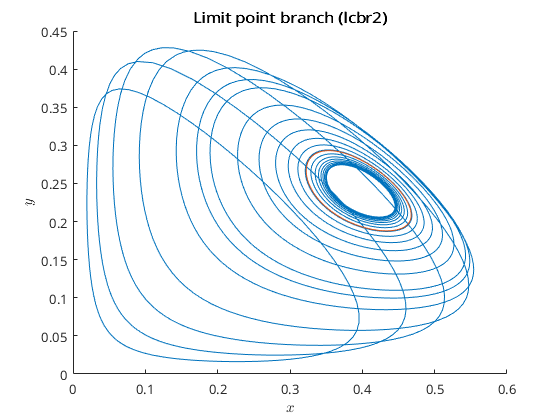

In [26]:
hold on
plot(lcbr2(1:4:4*(ntst*ncol+1),:), lcbr2(2:4:4*(ntst*ncol+1),:),'color', cmap(1,:))
plot(lcbr2(1:4:4*(ntst*ncol+1),pd_point_info.index), ...
     lcbr2(2:4:4*(ntst*ncol+1),pd_point_info.index),'color', cmap(2,:))
xlabel('$x$', 'Interpreter', 'LaTeX')
ylabel('$y$', 'Interpreter', 'LaTeX')
title('Limit point branch (lcbr2)')

## Continue period doubling bifurcation

In [27]:
[pd_pred, pd_pred_v] = init_PD_PD(odefile, lcbr2, ...
    pd_point_info(1), [ind.epsilon ind.b0], ntst, ncol);
opt.Backward = 0;
opt.MaxNumPoints = 30;
opt.IgnoreSingularity = [];
[pdbr, ~, pdbr_bif_data] = cont(@perioddoubling, pd_pred, pd_pred_v, opt);
opt.Backward = 1;
opt.Multipliers = 1; % needed for NS continuation from R2, see below
[pdbr_rev, ~, pdbr_rev_bif_data] = cont(@perioddoubling, pd_pred, pd_pred_v, opt);

first point found
tangent vector to first point found
Generalized period doubling(period = 1.000000e+00, parameters = 3.182303e-01, 4.117418e-01)
e = -5.859321e+01

elapsed time  = 4.5 secs
npoints curve = 30
first point found
tangent vector to first point found
Resonance 1:2 (period = 1.000000e+00, parameters = 3.362217e-01, 3.401301e-01)
(a,b)=(3.400447e+00, -1.292209e+01)
Generalized period doubling(period = 1.000000e+00, parameters = 1.092944e+00, 2.183704e-01)
e = 4.155483e+01

elapsed time  = 4.3 secs
npoints curve = 30


In [28]:
gpd1_point_info = pdbr_bif_data(strcmp({pdbr_bif_data.msg}, ...
    'generalized period doubling')==1);
gpd2_point_info = pdbr_rev_bif_data(strcmp({pdbr_rev_bif_data.msg}, ...
    'generalized period doubling')==1);
r12_point_info = pdbr_rev_bif_data(strcmp({pdbr_rev_bif_data.msg}, 'Resonance 2:1')==1);

### Plot of limit point of cycle and period doubling curves

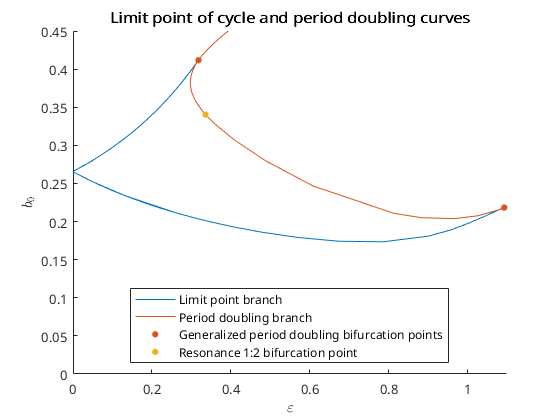

In [29]:
hold on
plot(lpcbr(epsilon_ind,:), lpcbr(b0_ind,:))
plot(lpcbr_rev(epsilon_ind,:), lpcbr_rev(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(lpcbr2(epsilon_ind,:), lpcbr2(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(lpcbr2_rev(epsilon_ind,:), lpcbr2_rev(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(pdbr(epsilon_ind,:), pdbr(b0_ind,:), 'color', cmap(2,:))
plot(pdbr_rev(epsilon_ind,:), pdbr_rev(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
% plot bifurcation points
plot(pdbr(epsilon_ind, gpd1_point_info.index), ...
     pdbr(b0_ind, gpd1_point_info.index), '.', 'color', cmap(2,:), ...
     'MarkerSize', 15)
plot(pdbr_rev(epsilon_ind, gpd2_point_info.index), ...
     pdbr_rev(b0_ind, gpd2_point_info.index), '.', 'color', cmap(2,:), ...
     'MarkerSize', 15, 'HandleVisibility', 'Off')
plot(pdbr_rev(epsilon_ind, r12_point_info.index), ...
     pdbr_rev(b0_ind, r12_point_info.index), '.', 'color', cmap(3,:), ...
     'MarkerSize', 15)
xlabel('$\varepsilon$', 'Interpreter', 'LaTeX')
ylabel('$b_0$', 'Interpreter', 'LaTeX')
title('Limit point of cycle and period doubling curves')
axis([0 1.1 0 0.45])
legend({'Limit point branch','Period doubling branch', ...
        'Generalized period doubling bifurcation points', ...
        'Resonance 1:2 bifurcation point'}, 'Location', 'South')

## Continue Neimark-Sacker bifurcation form resonance 1:2

In [30]:
[ns1_pred, ns1_pred_v] = init_R2_NS(odefile, pdbr_rev, ...
                         r12_point_info, [ind.epsilon ind.b0], ntst, ncol);
opt.Backward = 0;
ns1br = cont(@neimarksacker, ns1_pred, ns1_pred_v, opt);

first point found
tangent vector to first point found
Resonance 1:2 (period = 1.000000e+00, parameters = 3.362216e-01, 3.401301e-01)
(a,b)=(3.400446e+00, -1.292209e+01)
Resonance 1:2 (period = 1.000000e+00, parameters = -3.362222e-01, 3.401301e-01)
(a,b)=(3.400442e+00, -1.292209e+01)
Resonance 1:2 (period = 1.000000e+00, parameters = -1.189208e+00, 2.570226e+00)
(a,b)=(-9.796942e+01, 2.781081e+01)

elapsed time  = 9.8 secs
npoints curve = 30


### Plot of limit point of cycle, period doubling and Neimark-Sacker

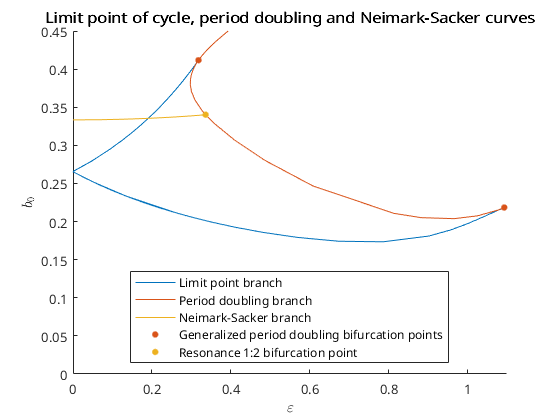

In [31]:
hold on
plot(lpcbr(epsilon_ind,:), lpcbr(b0_ind,:))
plot(lpcbr_rev(epsilon_ind,:), lpcbr_rev(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(lpcbr2(epsilon_ind,:), lpcbr2(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(lpcbr2_rev(epsilon_ind,:), lpcbr2_rev(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(pdbr(epsilon_ind,:), pdbr(b0_ind,:), 'color', cmap(2,:))
plot(pdbr_rev(epsilon_ind,:), pdbr_rev(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
plot(ns1br(epsilon_ind,:), ns1br(b0_ind,:), 'color', cmap(3,:))
% plot bifurcation points
plot(pdbr(epsilon_ind, gpd1_point_info.index), ...
     pdbr(b0_ind, gpd1_point_info.index), '.', 'color', cmap(2,:), ...
     'MarkerSize', 15)
plot(pdbr_rev(epsilon_ind, gpd2_point_info.index), ...
     pdbr_rev(b0_ind, gpd2_point_info.index), '.', 'color', cmap(2,:), ...
     'MarkerSize', 15, 'HandleVisibility', 'Off')
plot(pdbr_rev(epsilon_ind, r12_point_info.index), ...
     pdbr_rev(b0_ind, r12_point_info.index), '.', 'color', cmap(3,:), ...
     'MarkerSize', 15)
xlabel('$\varepsilon$', 'Interpreter', 'LaTeX')
ylabel('$b_0$', 'Interpreter', 'LaTeX')
title('Limit point of cycle, period doubling and Neimark-Sacker curves')
axis([0 1.1 0 0.45])
legend({'Limit point branch','Period doubling branch', 'Neimark-Sacker branch', ... 
        'Generalized period doubling bifurcation points', ...
        'Resonance 1:2 bifurcation point'}, 'Location', 'South')

## Continue period doubling bifurcation detected on lc2br

In [32]:
pd2_point_info = lcbr_pd_bif_data(strcmp({lcbr_pd_bif_data.msg}, ...
    'Period Doubling')==1);

In generel to conitnue in the reverse direction we just set `opt.Backward` to 1. However, in some case this may not work correctly. This is due to the use of global variables. By caling the init function `init_PD_PD` a second time this problem is avoided.

In [33]:
[pd2_pred, pd2_pred_v] = init_PD_PD(odefile, lcbr_pd, ...
                         pd2_point_info, [ind.epsilon ind.b0], ntst, ncol);
opt.Backward = 0;
[pd2br, ~, pd2br_bif_data] = cont(@perioddoubling, pd2_pred, pd2_pred_v, opt);
[pd2_pred, pd2_pred_v] = init_PD_PD(odefile, lcbr_pd, ...
                         pd2_point_info, [ind.epsilon ind.b0], ntst, ncol);
opt.Backward = 1;
[pd2br_rev, ~, pd2br_rev_bif_data] = cont(@perioddoubling, pd2_pred, pd2_pred_v, opt);

first point found
tangent vector to first point found

elapsed time  = 3.2 secs
npoints curve = 30
first point found
tangent vector to first point found
Resonance 1:2 (period = 2.000000e+00, parameters = 7.431665e-01, 1.838267e-01)
(a,b)=(-6.554194e+01, 1.623686e+01)

elapsed time  = 4.1 secs
npoints curve = 30


In [34]:
r12_point_info_2 = pd2br_rev_bif_data(strcmp({pd2br_rev_bif_data.msg}, 'Resonance 2:1')==1);

## Plot of limit point of cycle, period doubling and Neimark-Sacker curves

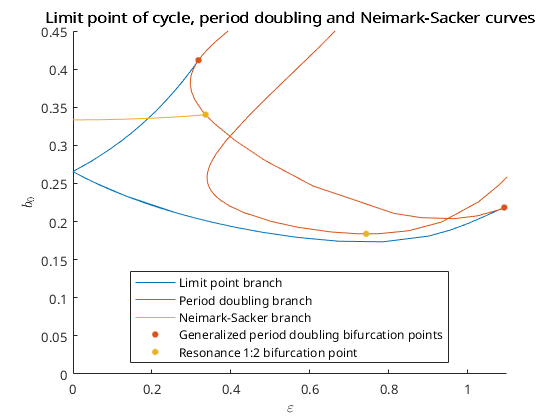

In [35]:
hold on
plot(lpcbr(epsilon_ind,:), lpcbr(b0_ind,:))
plot(lpcbr_rev(epsilon_ind,:), lpcbr_rev(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(lpcbr2(epsilon_ind,:), lpcbr2(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(lpcbr2(epsilon_ind,:), lpcbr2(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(lpcbr2_rev(epsilon_ind,:), lpcbr2_rev(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(pdbr(epsilon_ind,:), pdbr(b0_ind,:), 'color', cmap(2,:))
plot(pdbr_rev(epsilon_ind,:), pdbr_rev(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
plot(ns1br(epsilon_ind,:), ns1br(b0_ind,:), 'color', cmap(3,:))
plot(pd2br(epsilon_ind,:), pd2br(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
plot(pd2br_rev(epsilon_ind,:), pd2br_rev(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
% plot bifurcation points
plot(pdbr(epsilon_ind, gpd1_point_info.index), ...
     pdbr(b0_ind, gpd1_point_info.index), '.', 'color', cmap(2,:), ...
     'MarkerSize', 15)
plot(pdbr_rev(epsilon_ind, gpd2_point_info.index), ...
     pdbr_rev(b0_ind, gpd2_point_info.index), '.', 'color', cmap(2,:), ...
     'MarkerSize', 15, 'HandleVisibility', 'Off')
plot(pdbr_rev(epsilon_ind, r12_point_info.index), ...
     pdbr_rev(b0_ind, r12_point_info.index), '.', 'color', cmap(3,:), ...
     'MarkerSize', 15)
plot(pd2br_rev(epsilon_ind, r12_point_info_2.index), ...
     pd2br_rev(b0_ind, r12_point_info_2.index), '.', 'color', cmap(3,:), ...
     'MarkerSize', 15, 'HandleVisibility', 'Off')
xlabel('$\varepsilon$', 'Interpreter', 'LaTeX')
ylabel('$b_0$', 'Interpreter', 'LaTeX')
title('Limit point of cycle, period doubling and Neimark-Sacker curves')
axis([0 1.1 0 0.45])
legend({'Limit point branch','Period doubling branch', 'Neimark-Sacker branch', ... 
        'Generalized period doubling bifurcation points', ...
        'Resonance 1:2 bifurcation point'}, 'Location', 'South')

## Continue second Neimark-Sacker bifurcation form resonance 1:2 detected on `pd2br`

In [36]:
opt.Backward = 1;
opt.Multipliers = 1;
[ns2_pred, ns2_pred_v] = init_R2_NS(odefile, pd2br_rev, ...
                         r12_point_info_2, [ind.epsilon ind.b0], ntst, ncol);
[ns2br, ~, ns2br_bif_data] = cont(@neimarksacker, ns2_pred, ns2_pred_v, opt);

first point found
tangent vector to first point found
Resonance 1:2 (period = 2.000000e+00, parameters = 7.431631e-01, 1.838265e-01)
(a,b)=(-6.554695e+01, 1.623640e+01)
Resonance 1:3 (period = 2.000000e+00, parameters = 7.084323e-01, 1.798043e-01)
(b,Re(c))=(6.029799e+00 + (-2.026473e+00) i,9.133552e+00)
Resonance 1:4 (period = 2.000000e+00, parameters = 6.740352e-01, 1.772744e-01)
(A,d)=(1.032134e-01+ (-7.519980e-01) i, 8.715146e+01+ (-7.082131e+01) i)
Resonance 1:1 (period = 2.000000e+00, parameters = 6.019399e-01, 1.772509e-01)
ab=1.986685e+04

elapsed time  = 6.4 secs
npoints curve = 30


In [37]:
r11_point_info = ns2br_bif_data(strcmp({ns2br_bif_data.msg}, 'Resonance 1:1')==1);
r12_point_info_3 = ns2br_bif_data(strcmp({ns2br_bif_data.msg}, 'Resonance 1:2')==1);
r13_point_info = ns2br_bif_data(strcmp({ns2br_bif_data.msg}, 'Resonance 1:3')==1);
r14_point_info = ns2br_bif_data(strcmp({ns2br_bif_data.msg}, 'Resonance 1:4')==1);

## Plot of limit point of cycle, period doubling and Neimark-Sacker

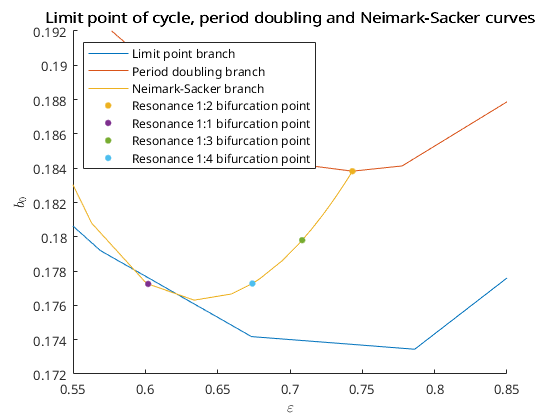

In [38]:
hold on
plot(lpcbr(epsilon_ind,:), lpcbr(b0_ind,:))
plot(lpcbr_rev(epsilon_ind,:), lpcbr_rev(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(lpcbr2(epsilon_ind,:), lpcbr2(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(lpcbr2_rev(epsilon_ind,:), lpcbr2_rev(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(pdbr(epsilon_ind,:), pdbr(b0_ind,:), 'color', cmap(2,:))
plot(pdbr_rev(epsilon_ind,:), pdbr_rev(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
plot(ns1br(epsilon_ind,:), ns1br(b0_ind,:), 'color', cmap(3,:))
plot(ns2br(epsilon_ind,:), ns2br(b0_ind,:), 'color', cmap(3,:), ...
     'HandleVisibility', 'Off')
plot(pd2br(epsilon_ind,:), pd2br(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
plot(pd2br_rev(epsilon_ind,:), pd2br_rev(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
% plot bifurcation points
plot(pdbr_rev(epsilon_ind, gpd2_point_info.index), ...
     pdbr_rev(b0_ind, gpd2_point_info.index), '.', 'color', cmap(2,:), ...
     'MarkerSize', 15, 'HandleVisibility', 'Off')
plot(pdbr_rev(epsilon_ind, r12_point_info.index), ...
     pdbr_rev(b0_ind, r12_point_info.index), '.', 'color', cmap(3,:), ...
     'MarkerSize', 15)
plot(pd2br_rev(epsilon_ind, r12_point_info_2.index), ...
     pd2br_rev(b0_ind, r12_point_info_2.index), '.', 'color', cmap(3,:), ...
     'MarkerSize', 15, 'HandleVisibility', 'Off')
plot(ns2br(epsilon_ind, r11_point_info.index), ...
     ns2br(b0_ind, r11_point_info.index), '.', 'color', cmap(4,:), ...
     'MarkerSize', 15)
plot(ns2br(epsilon_ind, r13_point_info.index), ...
     ns2br(b0_ind, r13_point_info.index), '.', 'color', cmap(5,:), ...
     'MarkerSize', 15)
plot(ns2br(epsilon_ind, r14_point_info.index), ...
     ns2br(b0_ind, r14_point_info.index), '.', 'color', cmap(6,:), ...
     'MarkerSize', 15)
xlabel('$\varepsilon$', 'Interpreter', 'LaTeX')
ylabel('$b_0$', 'Interpreter', 'LaTeX')
title('Limit point of cycle, period doubling and Neimark-Sacker curves')
legend({'Limit point branch','Period doubling branch', 'Neimark-Sacker branch', ... 
        'Resonance 1:2 bifurcation point', 'Resonance 1:1 bifurcation point', ...
        'Resonance 1:3 bifurcation point', 'Resonance 1:4 bifurcation point'}, ...
        'Location', 'NorthWest')
axis([0.55 0.85 0.172 0.192])

## Locate and continue periodic solution with period 4

In [39]:
amplitude = 1e-06;
opt.Backward = 0;
ntst = 40;
[lc3_pred, lc3_pred_v] = init_PD_LC2(odefile, lcbr_pd, pd2_point_info, ...
                                        ind.epsilon, ntst, ncol, amplitude);
[lc3br, ~, lc3br_bif_data] = cont(@limitcycle, lc3_pred, lc3_pred_v, opt);

first point found
tangent vector to first point found
Period Doubling (period = 4.000000e+00, parameter = 3.931995e-01)
Normal form coefficient = -1.362071e+00

elapsed time  = 4.0 secs
npoints curve = 30


In [40]:
pd_point_info_3 = lc3br_bif_data(strcmp({lc3br_bif_data.msg}, 'Period Doubling')==1);

In [41]:
ntst = 20;
opt.Backward = 0;
[pd3_pred, pd3_pred_v] = init_PD_PD(odefile, lc3br, pd_point_info_3, ...
                                        [ind.epsilon ind.b0], ntst, ncol);
[pd3br, ~, pd3br_bif_data] = cont(@perioddoubling, pd3_pred, pd3_pred_v, opt);
opt.Backward = 1;
[pd3_pred, pd3_pred_v] = init_PD_PD(odefile, lc3br, pd_point_info_3, ...
                                        [ind.epsilon ind.b0], ntst, ncol);
[pd3br_rev, ~, pd3br_rev_bif_data] = cont(@perioddoubling, pd3_pred, pd3_pred_v, opt);

first point found
tangent vector to first point found
Current step size too small (point 25)
elapsed time  = 4.1 secs
npoints curve = 25
first point found
tangent vector to first point found
Resonance 1:2 (period = 4.000003e+00, parameters = 7.431993e-01, 1.863972e-01)
(a,b)=(-2.664044e+02, -1.867027e+01)

elapsed time  = 6.0 secs
npoints curve = 30


## Plot of limit point of cycle, period doubling and Neimark-Sacker

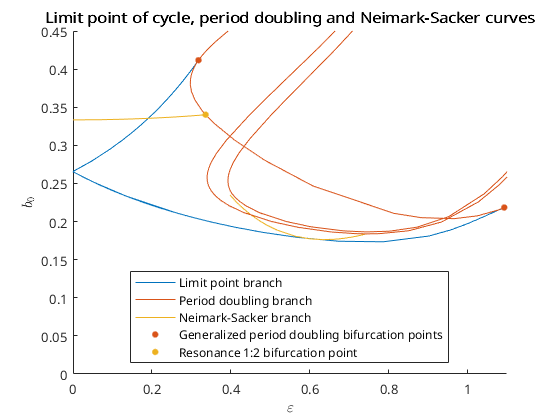

In [42]:
hold on
plot(lpcbr(epsilon_ind,:), lpcbr(b0_ind,:))
plot(lpcbr_rev(epsilon_ind,:), lpcbr_rev(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(lpcbr2(epsilon_ind,:), lpcbr2(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(lpcbr2_rev(epsilon_ind,:), lpcbr2_rev(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(pdbr(epsilon_ind,:), pdbr(b0_ind,:), 'color', cmap(2,:))
plot(pdbr_rev(epsilon_ind,:), pdbr_rev(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
plot(ns1br(epsilon_ind,:), ns1br(b0_ind,:), 'color', cmap(3,:))
plot(ns2br(epsilon_ind,:), ns2br(b0_ind,:), 'color', cmap(3,:), ...
     'HandleVisibility', 'Off')
plot(pd2br(epsilon_ind,:), pd2br(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
plot(pd2br_rev(epsilon_ind,:), pd2br_rev(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
plot(pd3br(epsilon_ind,:), pd3br(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
plot(pd3br_rev(epsilon_ind,:), pd3br_rev(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
% plot bifurcation points
plot(pdbr(epsilon_ind, gpd1_point_info.index), ...
     pdbr(b0_ind, gpd1_point_info.index), '.', 'color', cmap(2,:), ...
     'MarkerSize', 15)
plot(pdbr_rev(epsilon_ind, gpd2_point_info.index), ...
     pdbr_rev(b0_ind, gpd2_point_info.index), '.', 'color', cmap(2,:), ...
     'MarkerSize', 15, 'HandleVisibility', 'Off')
plot(pdbr_rev(epsilon_ind, r12_point_info.index), ...
     pdbr_rev(b0_ind, r12_point_info.index), '.', 'color', cmap(3,:), ...
     'MarkerSize', 15)
xlabel('$\varepsilon$', 'Interpreter', 'LaTeX')
ylabel('$b_0$', 'Interpreter', 'LaTeX')
title('Limit point of cycle, period doubling and Neimark-Sacker curves')
legend({'Limit point branch','Period doubling branch', 'Neimark-Sacker branch', ... 
        'Generalized period doubling bifurcation points', ...
        'Resonance 1:2 bifurcation point'}, 'Location', 'South')
axis([0 1.1 0 0.45])

## Continue Neimark-Sacker curve from 1:2 Resonance on `pd3br_rev`

In [43]:
ns3_point_info = pd3br_rev_bif_data(strcmp({pd3br_rev_bif_data.msg}, 'Resonance 2:1')==1);

In [44]:
opt.Backward = 1;
opt.MaxNumPoints = 25;
[ns3_pred, ns3_pred_v] = init_R2_NS(odefile, pd3br_rev, ns3_point_info, ...
                                        [ind.epsilon ind.b0], ntst, ncol);
[ns3br, ~, ns3br_bif_data] = cont(@neimarksacker, ns3_pred, ns3_pred_v, opt);                            

first point found
tangent vector to first point found
Resonance 1:2 (period = 4.000003e+00, parameters = 7.426057e-01, 1.863713e-01)
(a,b)=(-2.675726e+02, -1.864715e+01)
Chenciner bifurcation (period = 4.000003e+00, parameters = 7.427233e-01, 1.858395e-01)
Re(e)=2.950449e+06Resonance 1:3 (period = 4.000003e+00, parameters = 7.428326e-01, 1.857225e-01)
(b,Re(c))=(2.184648e+00 + (1.191218e+01) i,-8.920380e+00)
Resonance 1:4 (period = 4.000004e+00, parameters = 7.430226e-01, 1.850837e-01)
(A,d)=(-1.350900e-02+ (-6.480584e-01) i, -1.661644e+02+ (-6.198951e+02) i)
Resonance 1:1 (period = 4.000004e+00, parameters = 7.454391e-01, 1.842501e-01)
ab=-2.287599e+03

elapsed time  = 16.7 secs
npoints curve = 25


In [45]:
r11_point_info_2 = ns3br_bif_data(strcmp({ns3br_bif_data.msg}, 'Resonance 1:1')==1);
r12_point_info_4 = ns3br_bif_data(strcmp({ns3br_bif_data.msg}, 'Resonance 1:2')==1);
r13_point_info_2 = ns3br_bif_data(strcmp({ns3br_bif_data.msg}, 'Resonance 1:3')==1);
r14_point_info_2 = ns3br_bif_data(strcmp({ns3br_bif_data.msg}, 'Resonance 1:4')==1);

## Plot of limit point of cycle, period doubling and Neimark-Sacker

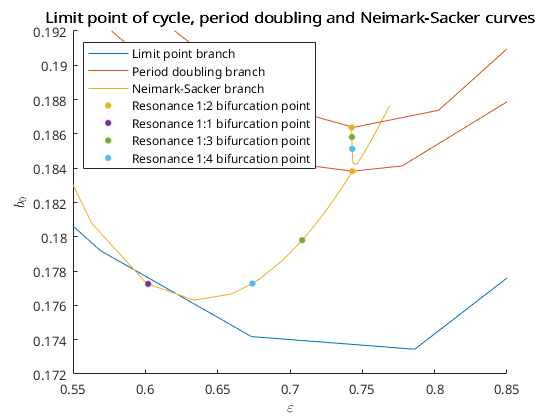

In [46]:
hold on
plot(lpcbr(epsilon_ind,:), lpcbr(b0_ind,:))
plot(lpcbr_rev(epsilon_ind,:), lpcbr_rev(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(lpcbr2(epsilon_ind,:), lpcbr2(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(lpcbr2_rev(epsilon_ind,:), lpcbr2_rev(b0_ind,:), 'color', cmap(1,:), ...
     'HandleVisibility', 'Off')
plot(pdbr(epsilon_ind,:), pdbr(b0_ind,:), 'color', cmap(2,:))
plot(pdbr_rev(epsilon_ind,:), pdbr_rev(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
plot(ns1br(epsilon_ind,:), ns1br(b0_ind,:), 'color', cmap(3,:))
plot(ns2br(epsilon_ind,:), ns2br(b0_ind,:), 'color', cmap(3,:), ...
     'HandleVisibility', 'Off')
plot(ns3br(epsilon_ind,:), ns3br(b0_ind,:), 'color', cmap(3,:), ...
     'HandleVisibility', 'Off')
plot(pd2br(epsilon_ind,:), pd2br(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
plot(pd2br_rev(epsilon_ind,:), pd2br_rev(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
plot(pd3br(epsilon_ind,:), pd3br(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
plot(pd3br_rev(epsilon_ind,:), pd3br_rev(b0_ind,:), 'color', cmap(2,:), ...
     'HandleVisibility', 'Off')
% plot bifurcation points
plot(pdbr_rev(epsilon_ind, gpd2_point_info.index), ...
     pdbr_rev(b0_ind, gpd2_point_info.index), '.', 'color', cmap(2,:), ...
     'MarkerSize', 15, 'HandleVisibility', 'Off')
plot(pdbr_rev(epsilon_ind, r12_point_info.index), ...
     pdbr_rev(b0_ind, r12_point_info.index), '.', 'color', cmap(3,:), ...
     'MarkerSize', 15)
plot(pd2br_rev(epsilon_ind, r12_point_info_2.index), ...
     pd2br_rev(b0_ind, r12_point_info_2.index), '.', 'color', cmap(3,:), ...
     'MarkerSize', 15, 'HandleVisibility', 'Off')
% bifurcation points on ns2
plot(ns2br(epsilon_ind, r11_point_info.index), ...
     ns2br(b0_ind, r11_point_info.index), '.', 'color', cmap(4,:), ...
     'MarkerSize', 15)
plot(ns2br(epsilon_ind, r13_point_info.index), ...
     ns2br(b0_ind, r13_point_info.index), '.', 'color', cmap(5,:), ...
     'MarkerSize', 15)
plot(ns2br(epsilon_ind, r14_point_info.index), ...
     ns2br(b0_ind, r14_point_info.index), '.', 'color', cmap(6,:), ...
     'MarkerSize', 15)
% bifurcation points on ns3
plot(ns3br(epsilon_ind, r12_point_info_4.index), ...
     ns3br(b0_ind, r12_point_info_4.index), '.', 'color', cmap(3,:), ...
     'MarkerSize', 15, 'HandleVisibility', 'Off')
plot(ns3br(epsilon_ind, r13_point_info_2.index), ...
     ns3br(b0_ind, r13_point_info.index), '.', 'color', cmap(5,:), ...
     'MarkerSize', 15, 'HandleVisibility', 'Off')
plot(ns3br(epsilon_ind, r14_point_info_2.index), ...
     ns3br(b0_ind, r14_point_info.index), '.', 'color', cmap(6,:), ...
     'MarkerSize', 15, 'HandleVisibility', 'Off')
xlabel('$\varepsilon$', 'Interpreter', 'LaTeX')
ylabel('$b_0$', 'Interpreter', 'LaTeX')
title('Limit point of cycle, period doubling and Neimark-Sacker curves')
legend({'Limit point branch','Period doubling branch', 'Neimark-Sacker branch', ... 
        'Resonance 1:2 bifurcation point', 'Resonance 1:1 bifurcation point', ...
        'Resonance 1:3 bifurcation point', 'Resonance 1:4 bifurcation point'}, ...
        'Location', 'NorthWest')
axis([0.55 0.85 0.172 0.192])

[1] Yu.A. Kuznetsov, S. Muratori, and S. Rinaldi, _Bifurcations and chaos in a periodic predator-prey
model_, Internat. J. Bifur. Chaos Appl. Sci. Engrg., 2 (1992), pp. 117–128. 